In [1]:
# !!pip install torch==1.9
!pip install --quiet transformers==4.5.0
!pip install --quiet pytorch-lightning==1.2.7
# !pip install -U torchtext==0.10

In [2]:
import json
import pandas as pd
import numpy as np
import torch
torch.cuda.empty_cache()
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from termcolor import colored
import textwrap

from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5TokenizerFast as T5Tokenizer
)
from tqdm.auto import tqdm

In [3]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 16, 10

In [4]:
pl.seed_everything(42)

42

In [11]:
!pip install  -q googledrivedownloader

In [15]:
# !gdown --id 1DXsaWG9p3oQjkKu19mx_ZQ8UjHtsoGHW

from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1DXsaWG9p3oQjkKu19mx_ZQ8UjHtsoGHW' , dest_path='/test/news_summary.csv')

In [16]:
df = pd.read_csv("/test/news_summary.csv", encoding='latin-1')
df.head()

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorc...,http://www.hindustantimes.com/bollywood/malaik...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS...,http://www.hindustantimes.com/patna/bihar-igim...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Sumedha Sehra,"03 Aug 2017,Thursday",Aaj aapne pakad liya: LeT man Dujana before be...,http://indiatoday.intoday.in/story/abu-dujana-...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Aarushi Maheshwari,"03 Aug 2017,Thursday",Hotel staff to get training to spot signs of s...,http://indiatoday.intoday.in/story/sex-traffic...,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [17]:
df = df[['text', 'ctext']]
df.head()

,text,ctext
0,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [18]:
df.columns = ['summary', 'text']
df = df.dropna()
df.head()

,summary,text
0,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [19]:
train_df, test_df = train_test_split(df, test_size=0.1)
train_df.shape, test_df.shape

((3956, 2), (440, 2))

In [20]:
class NewsSummaryDataset(Dataset):
    def __init__(
        self,
        data: pd.DataFrame,
        tokenizer: T5Tokenizer,
        text_max_token_len: int = 512,
        summary_max_token_len: int = 128
    ):
        self.tokenizer = tokenizer
        self.data = data
        self.text_max_token_len = text_max_token_len
        self.summary_max_token_len = summary_max_token_len
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]

        text = data_row['text']

        text_encoding = tokenizer(
            text,
            max_length=self.text_max_token_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors='pt'
        )

        summary_encoding = tokenizer(
            data_row['summary'],
            max_length=self.summary_max_token_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors='pt'
        )

        labels = summary_encoding['input_ids']
        labels[labels == 0] = -100 # to make sure we have correct labels for T5 text generation

        return dict(
            text=text,
            summary=data_row['summary'],
            text_input_ids=text_encoding['input_ids'].flatten(),
            text_attention_mask=text_encoding['attention_mask'].flatten(),
            labels=labels.flatten(),
            labels_attention_mask=summary_encoding['attention_mask'].flatten()
        )

In [21]:
class NewsSummaryDataModule(pl.LightningDataModule):
    def __init__(
        self,
        train_df: pd.DataFrame,
        test_df: pd.DataFrame,
        tokenizer: T5Tokenizer,
        batch_size: int = 8,
        text_max_token_len: int = 512,
        summary_max_token_len: int = 128
    ):
        super().__init__()

        self.train_df = train_df
        self.test_df = test_df
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.text_max_token_len = text_max_token_len
        self.summary_max_token_len = summary_max_token_len

    def setup(self, stage=None):
        self.train_dataset = NewsSummaryDataset(
            self.train_df,
            self.tokenizer,
            self.text_max_token_len,
            self.summary_max_token_len
        )
        self.test_dataset = NewsSummaryDataset(
            self.test_df,
            self.tokenizer,
            self.text_max_token_len,
            self.summary_max_token_len
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2
        )

In [22]:
MODEL_NAME = 't5-base'

tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [23]:
text_token_counts, summary_token_counts = [], []

for _, row in train_df.iterrows():
    text_token_count = len(tokenizer.encode(row['text']))
    text_token_counts.append(text_token_count)

    summary_token_count = len(tokenizer.encode(row['summary']))
    summary_token_counts.append(summary_token_count)   

Token indices sequence length is longer than the specified maximum sequence length for this model (689 > 512). Running this sequence through the model will result in indexing errors


<AxesSubplot:ylabel='Count'>

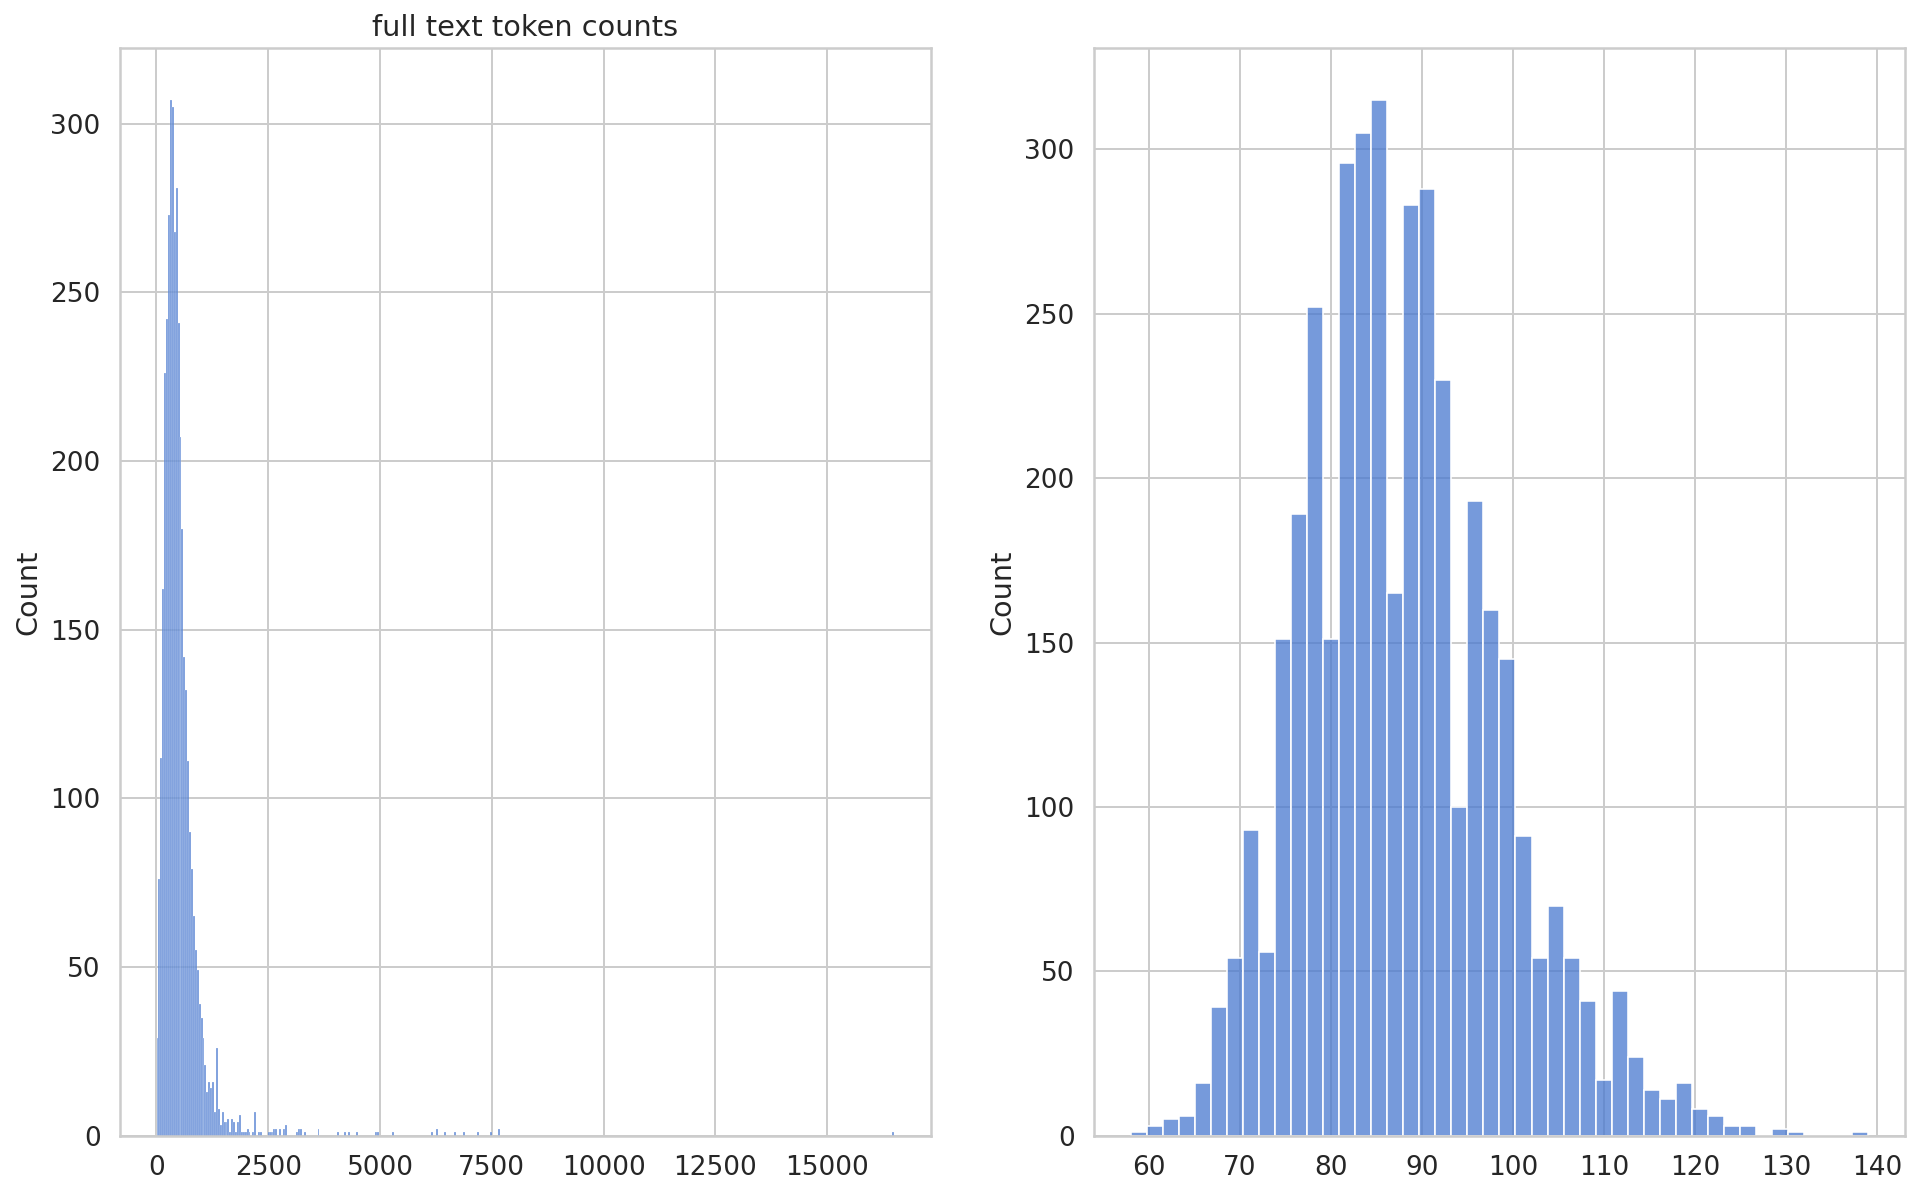

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.histplot(text_token_counts, ax=ax1)
ax1.set_title('full text token counts')
sns.histplot(summary_token_counts, ax=ax2)

In [25]:
N_EPOCHS = 3
BATCH_SIZE = 8

data_module = NewsSummaryDataModule(train_df, test_df, tokenizer)

In [26]:
class NewsSummaryModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, return_dict=True)
    
    def forward(self, input_ids, attention_mask, decoder_attention_mask, labels=None):
        output = self.model(
            input_ids,
            attention_mask=attention_mask,
            labels=labels,
            decoder_attention_mask=decoder_attention_mask
        )

        return output.loss, output.logits

    def training_step(self, batch, batch_size):
        input_ids = batch['text_input_ids']
        attention_mask = batch['text_attention_mask']
        labels = batch['labels']
        labels_attention_mask = batch['labels_attention_mask']

        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
        )

        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_size):
        input_ids = batch['text_input_ids']
        attention_mask = batch['text_attention_mask']
        labels = batch['labels']
        labels_attention_mask = batch['labels_attention_mask']

        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
        )

        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_size):
        input_ids = batch['text_input_ids']
        attention_mask = batch['text_attention_mask']
        labels = batch['labels']
        labels_attention_mask = batch['labels_attention_mask']

        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
        )

        self.log("test_loss", loss, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=0.0001)

In [27]:
model = NewsSummaryModel()

Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/892M [00:00<?, ?B/s]

In [28]:
# %load_ext tensorboard
# %tensorboard --logdir ./lightning_logs

In [29]:
checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints',
    filename='best-checkpoint',
    save_top_k=1,
    verbose=True,
    monitor='val_loss',
    mode='min'
)

logger = TensorBoardLogger("lightning_logs", name='news-summary')

trainer = pl.Trainer(
    logger=logger,
    # checkpoint_callback=checkpoint_callback,
    max_epochs=N_EPOCHS,
    gpus=1,
    progress_bar_refresh_rate=30
)

In [30]:
trainer.fit(model, data_module)

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)


Validation sanity check: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Training: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validating: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1

In [33]:
trained_model = NewsSummaryModel.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path
)
trained_model.freeze()

In [34]:
def summarizeText(text):
    text_encoding = tokenizer(
        text,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors='pt'
    )
    generated_ids = trained_model.model.generate(
        input_ids=text_encoding['input_ids'],
        attention_mask=text_encoding['attention_mask'],
        max_length=150,
        num_beams=2,
        repetition_penalty=2.5,
        length_penalty=1.0,
        early_stopping=True
    )

    preds = [
            tokenizer.decode(gen_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
            for gen_id in generated_ids
    ]
    return "".join(preds)

In [35]:
sample_row = test_df.iloc[0]
text = sample_row['text']
model_summary = summarizeText(text)
text

/opt/conda/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/BinaryOps.cpp:461.)
  return torch.floor_divide(self, other)


'Washington, Mar 27 (PTI) A 38-year-old woman in the US, who was apprehended twice for allegedly trying to jump the White House fence last week, has been arrested for scaling a fence at the Treasury Building. Marci Anderson Wahl of Everett, Washington, was arrested after an alarm sounded at about 2:15 am yesterday when she scaled a fence at the Treasury Building, next to the White House. Police said Wahl has told them she was there to speak to US President Donald Trump, the CNN reported. She was charged with unlawful entry and contempt of court. Wahl was first arrested on March 21 last week for trying to jump the White House fence. Once in custody, it was determined that Wahl had been issued a "stay away" order for the White House complex after the incident. On March 21, officers saw Wahl walking and staring at the White House complex before discovering she had jumped a fence on the south side but got stuck. Officers found her hanging from the inside of the fence by her shoelaces, whic

In [36]:
sample_row['summary']

'A woman, who was arrested twice last week for trying to jump the White House fence, has been arrested for the third time for scaling a fence at the Treasury Building, next to the White House. The woman, who told officers that she wanted to speak to President Donald Trump, has been charged with unlawful entry and contempt of court.'

In [37]:
model_summary

'A 38-year-old woman in the US, who was apprehended twice for allegedly trying to jump the White House fence last week, has been arrested for scaling a fence at the Treasury Building. Police said she had told them she was there to speak to US President Donald Trump. She was charged with unlawful entry and contempt of court.'

In [38]:
sample_row = test_df.iloc[1]
text = sample_row['text']
model_summary = summarizeText(text)
text

'The tea stall in Guajarat\'s Vadnagar where Prime Minister Narendra Modi once sold tea during his childhood is all set to become a tourist spot with the Centre deciding to give it a face-lift. The stall is located on one of the platforms of the Vadnagar Railway station. Converting the stall into a tourist spot is part of a larger project of putting Modi\'s birthplace Vadnagar in Mehsana district of Gujarat on the world tourism map. Officials of the Ministry of Culture and Tourism and Archaeological Survey of India (ASI) visited the town yesterday. The team of officials was led by Union Culture Mahesh Sharma, who later announced that the original charm of the tea stall will be preserved while giving it a modern touch. "Apart from being the birthplace of our PM, Vadnagar is an important historical centre having famous Sharmishta Lake and a step-well. The ASI had recently found remains of a Buddhist Monastery during excavation, which is still going on," Sharma told reporters at Gandhinag

In [39]:
sample_row['summary']

"A tea stall in Gujarat's Vadnagar railway station where PM Narendra Modi used to sell tea during his childhood is set to become a tourist spot. Union Culture Minister Mahesh Sharma visited the place on Sunday and said the tea stall will be developed as a part of a ?100-crore project to develop Vadnagar and surrounding areas as tourist destinations. "

In [40]:
model_summary

"The tea stall in Guajarat's Vadnagar where Prime Minister Narendra Modi once sold tea during his childhood is set to become a tourist spot with the Centre deciding to give it a face-lift. Converting the stall into a tourist spot is part of a larger project of putting Modi's birthplace Vadnagar in Mehsana district of Gujarat on the world tourism map."

In [41]:
model_summary = summarizeText("""Representative image
Representative image
ICICI Lombard
Trade
WatchlistPortfolioMessageSet Alert
 
 
NSELIVE
16 Apr, 2021 15:58
 1,417.15  30.55 (2.20%)
Volume 825956 Todays L/H 1,375.001,428.00
More 
Private general insurer, ICICI Lombard General Insurance posted a 22.6 percent year-on-year (YoY) rise in its March quarter (Q4) net profit at Rs 345.68 crore.

The general insurer had collected gross direct premium income (GDPI) of Rs 3,478 crore for Q4, a growth of 9.4 percent YoY.

The return on average equity (ROAE) was 21.7 percent in FY21 compared to 20.8 percent in FY20. ROAE was 18.8 percent in Q4FY21 compared to 18.8 percent in Q4FY20.

Solvency ratio was 2.90 at March 31, 2021 as against 2.76 at December 31, 2020. This was higher than the minimum regulatory requirement of 1.50. Solvency ratio was 2.17x at March 31, 2020.

As far as the COVID-19 health claims are concerned, general insurers saw 9,80,000 claims being filed worth Rs 14,000 crore.""")
model_summary

'Private general insurer, ICICI Lombard General Insurance posted a 22.6 percent year-on-year (YoY) rise in its March quarter net profit at?345.68 crore. The company had collected gross direct premium income (GDPI) of?3,478 crore for Q4, a growth of 9.4 percent YoY.'

In [42]:
import pickle

In [43]:
filename = open('text_summarization_model.pkl', 'wb')
pickle.dump(trained_model.model, filename)

In [44]:
model = pickle.load(open('text_summarization_model.pkl', 'rb'))

In [45]:
def summarizeText(text):
    text_encoding = tokenizer(
        text,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors='pt'
    )
    generated_ids = model.generate(
        input_ids=text_encoding['input_ids'],
        attention_mask=text_encoding['attention_mask'],
        max_length=150,
        num_beams=2,
        repetition_penalty=2.5,
        length_penalty=1.0,
        early_stopping=True
    )

    preds = [
            tokenizer.decode(gen_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
            for gen_id in generated_ids
    ]
    return "".join(preds)

In [46]:
model_summary = summarizeText("""I’m not sure how long it was before I realized that the shuttle train never stopped, probably about the time it dawned on me that the people who had gotten on with me were gone. The train is supposed to run from Grand Central to Times Square, one stop, five minutes at the absolute most. But it had been… how long had it been? I don’t know, I was reading my book. I can space out pretty bad sometimes. Family lore has it that I slept right through a freak tornado that ripped off our roof. But the bluish fluorescent lights on the train flickered out with a hum, and when they turned on again, I realized something was amiss. The windows were turned into mirrors by the underground darkness, and in them was a face with a mischievous grin, complemented by a rakish light in the eyes and a tumble of curly brown hair. Samill, the trickster. 

He materialized from the window. “It’s been some time since we’ve seen each other.”

“I can’t say I’ve missed you much, Samill,” I replied, sighing and putting my book down. He laughed heartily in response. 

“All of the wonders I’ve shown you and you don’t even have a smile to spare for me?” He had a note of mock offense in his voice. “I guess I’ll have to take this little adventure to someone else.”

“Go ahead. I won’t mind.”

He smiled, more broadly still. “Just kidding, it has to be you.”

“Why?”

“You’re the only one who’s done it before and let’s just say I need you to survive.”

He meant that I’m the only mortal to travel to the realm of the gods and return both alive and a mortal. I did it when I was a girl; it was a whole thing I can’t get into now, but Samill was behind that, too. He damn near got me killed. 

“I don’t need anything from you this time, Samill. And I’m not a kid anymore. Why would I take this risk?”

Samill appraised me. “Indeed, you are no longer a kid.” He turned his head to the side and held his fingers to his eyes like a camera lens. “A fine young woman, might I say. Are you in want of a companion?”

“No,” I replied flatly. 

“Alright,” he said, smiling. “No need to be testy, just asking. Anyway, I need you to get something that was stolen from me.”

“Get it yourself.”

“Oh no, I can’t show my face there. But you would be able to slip right in and out, unnoticed.”

“Surely there’s some other mortal in this world or another, aching for adventure or in need of your favors. I don’t need anything.” I looked down at my phone to check the time, but the screen displayed Samill’s mischievous face in profile. 

Samill looked at me seriously for some time, calculating something as he always did. “How is your sister, Stella? She must be twenty-seven years old now, am I right?”

The air went out of me. What was he planning to do to her? 

He narrowed his eyes, a playful grin forming in one corner of his mouth. “Don’t worry, love. Your sister is fine. I kept my end of that bargain.”

“And I paid a huge price. We’re even.”

He crouched in front of me. Up close, I could see the glow of his skin and smell his hair; unearthly and unfathomable.

“I can give you your magic back. You and Stella.”

I froze, not daring to breathe. Samill took our magic in exchange for Stella’s life. We’d lived more than ten years without it. Sometimes, I wonder if I dreamed that I had it: a memory of fire dancing on my fingertips or chasing Stella on the surface of a lake; ephemeral, slipping from me like water in a palm. A gnawing, gaping longing opened up in me.

“Ah,” Samill said, standing up smiling. “You’ve missed your magic. I do wonder sometimes how any mortal can bear life without it.”

“Magic attracts the gods and all mortals are better off without that.”

Samill grabbed his chest. “My poor heart. Come, let me show you something.”

He beckoned me to the front of the train. It had stopped moving. With a dramatic swipe of his hand, the front of the train melted away, revealing the damp entrance to a long tunnel. 

“I need you to find the goddess Badha and retrieve the emerald she’s guarding. She’s blind and can only sense the gods. You will be able to go without notice,” he looked down at me out of the corner of his eye.

I shot him a sharp look. “The underworld? Last time was different it was the heavenly gods. This is the realm of the dead, I won’t make it out. They won’t let me cross back into the living.”

“If you speak your secret name to the guardian, he will let you pass alive. And if you give me the emerald, I’ll return your magic to you and your sister.”

“But my secret name is for my passage into the afterlife. I can’t speak it twice.”

“That’s just superstition. Encouraged by the gods, mind you, because your secret name has power and the gods know it. But you can speak it more than once. I give you my word.”

I faced him and looked defiantly into his eyes. “No, sorry. I don’t need the magic, neither does Stella. Find someone else.”

Samill laughed. “Well, Phoebe, I’d hoped you’d come around on your own. But barring that,” he shoved me through the front of the train and I landed right on my face in the rock and the mud. Before I could stand up, he smiled at me and waved his arm, making himself and the train disappear over my head. 

I made a hearty effort to bang on the now closed wall where Samill had thrown me through, but it didn’t work. If I was going to get out of there, I knew I’d have to descend this tunnel to figure it out. I pulled up my phone. Dead. Technology didn’t really work in the magical realms. The gods are terrified of it; Google is better at reading our minds than they are. It took some time for my eyes to adjust to the darkness, but when they did I noticed tiny dots of light embedded in the rock. I hit my face on the occasional tree root that was hanging from the top of the tunnel. 

I can’t say how long I walked, but at some point, minutes, hours or days later I arrived at a dried up river bed that I knew I’d have to cross to continue. Water is powerful and even its absence can be a trap set by a sorcerer or a god. I crouched down and put my ear to the ground. The whoosh of running water filled my ears. Some kind of underground river. I pressed my finger into a spot of soft mud beneath a rock and pearly liquid that looked like a cross between clouded water and honey emerged. I recognized it from old stories my grandmother told Stella and me, the River of No Name that runs through the center of the earth. It would expect payment of some kind, I reckoned. All enchanted crossings did. But I had nothing on me. I was unprepared. I tried my phone, since it was the most expensive thing I had. I placed it gingerly on the rocks, but moments later the phone launched itself back at me. Ok, that wasn’t going to work. I thought for a few minutes and then realized: the river would want my name. I leaned over to the rocks and whispered “Phoebe,” but the rocks let out an agitated hiss and rumbled. I wiped my hands on my jeans and looked up, cursing Samill. The river wanted my secret name. I was forced to trust what Samill said about my secret name not losing power if I say it more than once. I bent my face even lower this time and said, in as low a voice as possible, the name spoken to me once by my mother the day I was born and written on my heart, Efweth. 

Water coursed through the rocks, gold and white and pleasant. It leveled off when it was a few inches high and pulled itself to either side, allowing me to pass over the rocks. Eventually, I came to the end of the tunnel which was a large, circular cavern with walls made of rocks and mud. The light in the rocks was brighter here, so I was able to see more easily. It seemed I was alone. I walked around the room, my hand on the walls, feeling for some exit or hidden door, but I came up empty. I looked up, but whatever was above me was either too high or too occluded by the darkness for me to see it. 

“Ok, Samill. What am I doing here? Help me out?”

Just then, an enormous woman descended from the ceiling; twenty-feet tall with a tangled mass of hair falling over her shoulders. She seemed old, older than the earth, but also ageless. As soon as I noticed something that would indicate her age, a wrinkle, a grey hair, it would fade away before I could be sure it was there. This must be Badha. 

“Samill? Are you here you nasty little imp? I told you if I ever saw you again I’d rip you to shreds and it would take you three millennia to stitch yourself together.”

I pushed myself into the wall and held my breath, not wanting to make a sound. The goddess moved a few steps forward and backward, shaking the cavern as she did. 

“No it can't be Samill. He couldn't be... But who said your name? Why would anyone speak of you here?”

She moved her arm around the cavern to feel. I pressed myself further against the wall. 

“Make yourself known, whoever you are. Another useless goblin? Be gone, goblin. I’ve nothing for you here.”

I looked all over her for some sign of an emerald, nothing on her neck, nothing on her fingers or in her hair. She made herself some kind of beverage and after she was done, she sat down with her great legs out in front of her. I was standing next to her massive calf, I could have reached across and grabbed it if I wanted to. She sipped from her cup and paused, putting her ear up like a curious dog. She sipped again and got on all fours. I had to run toward the entrance of the cavern to avoid her as she changed positions. Then she put her ear to the ground and knelt up. 

“Mortal, I know you’re here.”

Damnit, Samill.

“Tell me why you’re here, mortal.”

I neither replied nor moved so much as an eyelid.

“The river told me mortal. I’ll say your secret name if you don’t answer me. I don’t think you want that.”

I wasn’t sure what the consequences of that would be; should I call her bluff or answer her? Everyone in my culture is given a secret name at birth, whispered in their left ears by our mothers at the moment of birth. We are never to speak it until we die. We were told to always guard it as the name possesses great power that could be used to harm us or someone else. 

“Did Samill send you?”

“Yes,” I croaked out. I was very thirsty. 

She laughed, quietly at first and then so forcefully the walls shook. 

“Tell me, mortal, what did he tell you to get?”

“An emerald.” 

She laughed again, this time wiping tears from her cheeks. 

“My sweet child, Samill knows I don’t have that emerald. What did he promise you?”

My stomach dropped. What had he set me up for? 

“Eternal youth? Love? Please, tell me.” She was still laughing and occasionally broke into wheezing coughs. 

“He said he’d return my magic.”

She stopped laughing. “Who took it?”

"He did, Samill.”

“Why?”

“In exchange for my sister’s life.”

“And you believed him, when he said he’d return your magic?”

“I don’t know. I refused him. But when I refused he threw me down here.”

She brought her hand to her chin like she was thinking very hard.

“I don’t have the emerald, dear. Samill knows that.”

“Ok, then, I’ll just get out of your hair.”

She cackled. “You’re in the realm of the dead. You can’t return. You must know that.”

“Samill said…”

“Samill lied,” she said, still wiping tears of laughter from her blank eyes. “You can’t return. And I’m hungry, come here.” She swiped her arms out again, narrowly missing me.

I ran again to the entrance of the cavern and had nearly managed to get away when a tree root ripped from the floor and pulled me back. “I told you, there’s no returning for you, mortal. Samill as good as killed you. I don’t know what you did to piss him off.”

I had no weapons. No magic. No way out. I closed my eyes and readied myself for my fate. I wondered what death would be like if I died already in the underworld. Then I got an idea. Lining the walls of the cavern and up into the ceiling were tree roots, the ones that brought me back into the cavern when I tried to escape. I escaped from the root holding me and ran across, another root shot out and chased me. I ran back and forth around the cavern, narrowly avoiding the roots as I did. 

The whole time Badha was laughing. “Mortals always fight so hard. So entertaining. Well, I’ll be back in a minute when you’re dead.” She stood up but fell right away as the roots pulled her back down. I’d trapped her in them. She pulled and grabbed at them, breaking a few, but they held. I knew they wouldn’t hold long, so I made one final move. I leapt up onto the roots holding Badha, the tips of new ones chasing me as I did, and ran headlong into her chest, dodging out of the way at the last second. The root didn’t find me, but did find Badha’s chest, shooting straight through it and out the other side. 

She gasped and choked. “No, no. This isn’t possible.” She weakly pulled at the root in her chest, but then she started to disintegrate into the dirt below her, her flesh and hair and clothes falling into so much dust. 

I was stunned. I thought I would incapacitate her, not kill her. I had no idea what the tree was made of that it was strong enough to kill a goddess, but I ran out of there as quickly as my feet would carry me. The River of No Name parted for me, it did not expect a second payment. I clambered back up the tunnel as fast as I could, falling and tripping as I went. I reached the end of the tunnel, still closed off. 

“Samill! Let me out of here.” I could see the tunnel starting to fall away too. Soon the ground beneath my feet would be gone. “You feckless bastard let, me, out!”

Nothing. 

"Damn it,” I said, realizing that this wall was the Guardian and I needed to tell it my name or I’d fall into the creeping oblivion below. “Efweth,” I said as quietly as my adrenaline would allow. 

I was back on the shuttle train. Samill sat jauntily across from me, legs crossed, smiling as though he could hear a distant good tune. The only evidence I had that anything had happened was that I was covered in dirt. 

“I’m going to KILL you,” I shouted and ran over and started battering him with my fists. “Kill you. There was no emerald.”

He restrained me easily, smiling. “I know. I needed her killed. I knew you could do it.”

My jaw fell open. “Why? Why didn’t you just kill her yourself?”

“This is the problem with all of you magical mortals who chose to integrate into the larger society. You missed all of your lessons. Celestial gods cannot descend into the underworld. Only humans can. I would immediately evaporate if I stepped down there.”

“Why me?,” I asked, crying now. “Why? It could have been anyone.”

He shook his head. “No, not anyone.” He sat back down the seat. “It had to be someone with your talents.”

“I don’t have any talents,” I wept. My shoulders were shaking. “I was just trying to survive.”

“And yet, most would not. Just as most children would not have survived the ordeal you went through. No, it had to be you, I’m sorry.”

He stood up again and walked to the door of the train, which I realized was moving again. 

“Here,” he said, reaching into a pocket in his garment. “Your magic.” 

“No! No, please,” I begged. “I don’t need it. Keep it.”

He smiled again, larger than before. “I need you to have it. I’m not done with you yet, Efweth.”

The loudspeaker called out, “Stand clear of the closing doors, please,” and he snapped his fingers in my direction, stepped out and disappeared into the crowd.

People filed into the train and I wiped the tears from my face and tucked my hair behind my ears, but people still avoided sitting next to me, covered as I was in mud and dust. I held up my left hand, cupping it around my right forefinger as though to protect it from the wind, and produced a dancing blue flame from the tip of my finger. 

I couldn’t stop myself from smiling.""")
model_summary

'The shuttle train was supposed to run from Grand Central to Times Square, one stop, five minutes at the absolute most. But it had been... how long had it been? I don’t know, I was reading my book. Family lore has it that I slept right through a freak tornado that ripped off our roof.'